In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

In [4]:
image_size = (128,128)
batch_size = 10

training_data_dir = r'C:\Users\snirm\Devl\ML\Final-Project\Sessions\Test Session 6\Train'
validation_data_dir = r'C:\Users\snirm\Devl\ML\Final-Project\Sessions\Test Session 6\Validation'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 35416 images belonging to 100 classes.
Found 3986 images belonging to 100 classes.


[[[ 15.  28.  23.]
  [ 13.  24.  18.]
  [ 14.  23.  12.]
  ...
  [  5.   7.   3.]
  [  0.   5.   0.]
  [  0.   5.   0.]]

 [[ 68.  91.  95.]
  [ 29.  42.  45.]
  [ 16.  25.  16.]
  ...
  [  1.   4.   0.]
  [  2.   6.   1.]
  [ 11.  15.   1.]]

 [[ 69. 118. 136.]
  [ 15.  25.  22.]
  [  8.  18.  10.]
  ...
  [  1.   3.   1.]
  [  1.   3.   3.]
  [ 89.  88.  46.]]

 ...

 [[241. 240. 235.]
  [255. 255. 255.]
  [255. 253. 250.]
  ...
  [101.  58.  17.]
  [ 52.  24.  18.]
  [ 42.  27.  19.]]

 [[186. 188. 184.]
  [193. 195. 192.]
  [207. 208. 205.]
  ...
  [141. 114.  35.]
  [141. 117.  37.]
  [121.  90.  37.]]

 [[189. 190. 194.]
  [191. 194. 194.]
  [190. 192. 192.]
  ...
  [131. 111.  47.]
  [142. 115.  39.]
  [136. 108.  44.]]]


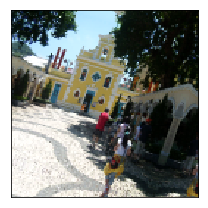

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(1):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    print(x_batch[i])
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

In [75]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [76]:
base_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))

In [77]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 63, 63, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 63, 63, 32)   0           batch_normalization_470[0][0]    
__________________________________________________________________________________________________
conv2d_471

In [78]:
classCount = 100

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='sigmoid')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='sigmoid')(x) #dense layer 2
x=Dense(512,activation='sigmoid')(x) #dense layer 3
preds=Dense(classCount, activation='softmax')(x) #final layer with softmax activation

model_final=Model(inputs=base_model.input,outputs=preds)


In [79]:
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0), metrics=["accuracy"])

In [80]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

3541


In [81]:
class LossAccHisotry(Callback):
    def on_train_begin(self,logs={}):
        self.loss_history = []
        self.accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
        
    #def on_batch_end(self,batch, logs={}):
        #self.loss_history.append(logs.get('loss'))
        #self.accuracy_history.append(logs.get('acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss_history.append(logs.get('val_loss'))
        self.val_accuracy_history.append(logs.get('val_acc'))
        self.loss_history.append(logs.get('loss'))
        self.accuracy_history.append(logs.get('acc'))
        print(logs)
    
history = LossAccHisotry()

In [82]:
import time

networkfileName = "InceptionV3_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

In [83]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 63, 63, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 63, 63, 32)   0           batch_normalization_470[0][0]    
__________________________________________________________________________________________________
conv2d_471

In [71]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [85]:
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=10
                   ,callbacks = [history, checkpoint, early])

Epoch 1/10
3540/3541 [============================>.] - ETA: 0s - loss: 3.2925 - acc: 0.2826{'val_loss': 2.761465138187973, 'val_acc': 0.3928750627269951, 'loss': 3.2923717113131894, 'acc': 0.2825509857924848}

Epoch 00001: val_acc improved from -inf to 0.39288, saving model to InceptionV3_1552159972.h5
3541/3541 [==============================] - 1081s 305ms/step - loss: 3.2924 - acc: 0.2826 - val_loss: 2.7615 - val_acc: 0.3929
Epoch 2/10
3540/3541 [============================>.] - ETA: 0s - loss: 2.7013 - acc: 0.3984{'val_loss': 2.390507325059017, 'val_acc': 0.4570998495180165, 'loss': 2.7013809387444008, 'acc': 0.3984353001115989}

Epoch 00002: val_acc improved from 0.39288 to 0.45710, saving model to InceptionV3_1552159972.h5
3541/3541 [==============================] - 1045s 295ms/step - loss: 2.7013 - acc: 0.3985 - val_loss: 2.3905 - val_acc: 0.4571
Epoch 3/10
3540/3541 [============================>.] - ETA: 0s - loss: 2.4232 - acc: 0.4535{'val_loss': 2.163198386312907, 'val_ac

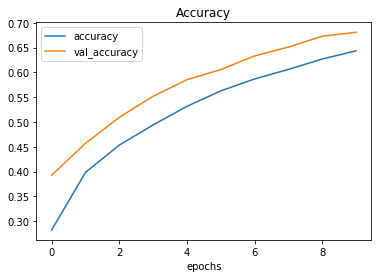

In [86]:
import matplotlib.pyplot as plt
x = range(0, len(history.accuracy_history))
plt.plot(x, history.accuracy_history)
plt.plot(x, history.val_accuracy_history)
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

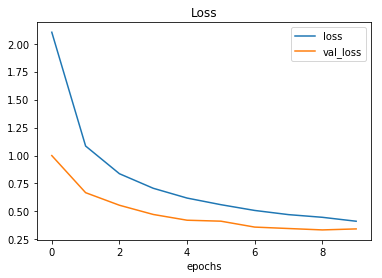

In [74]:
x = range(0, len(history.loss_history))
plt.plot(x, history.loss_history)
plt.plot(x, history.val_loss_history)
plt.xlabel('epochs')
plt.title('Loss')
plt.legend(['loss', 'val_loss'])